# Assigment 2: CAMSHIFT
## Paper
Lies das Paper "Bradski_etal_1998_camshift.pdf" im KVV (unter "Resources"). 

## Histogramm berechnen
* Implementiere eine Funktion, die ein Farbhistogramm erstellt. Übergebe entweder ein Bild und ein ROI, oder das dem ROI unterliegende Bild. 
* Hierzu ermögliche durch die Übergabe eines zweiten (bzw. dritten) Parameters die Zusammenfassung von Farbwerten in n Bins. 
* Lade das Bild "images/racecar.png" und konvertiere das Bild in den HSV-Farbraum. Plotte den Hue-Kanal. (**RESULT**)

[0.61111111 0.14383562 0.57254902]
{0.0: 0, 0.00390625: 1, 0.0078125: 2, 0.01171875: 3, 0.015625: 4, 0.01953125: 5, 0.0234375: 6, 0.02734375: 7, 0.03125: 8, 0.03515625: 9, 0.0390625: 10, 0.04296875: 11, 0.046875: 12, 0.05078125: 13, 0.0546875: 14, 0.05859375: 15, 0.0625: 16, 0.06640625: 17, 0.0703125: 18, 0.07421875: 19, 0.078125: 20, 0.08203125: 21, 0.0859375: 22, 0.08984375: 23, 0.09375: 24, 0.09765625: 25, 0.1015625: 26, 0.10546875: 27, 0.109375: 28, 0.11328125: 29, 0.1171875: 30, 0.12109375: 31, 0.125: 32, 0.12890625: 33, 0.1328125: 34, 0.13671875: 35, 0.140625: 36, 0.14453125: 37, 0.1484375: 38, 0.15234375: 39, 0.15625: 40, 0.16015625: 41, 0.1640625: 42, 0.16796875: 43, 0.171875: 44, 0.17578125: 45, 0.1796875: 46, 0.18359375: 47, 0.1875: 48, 0.19140625: 49, 0.1953125: 50, 0.19921875: 51, 0.203125: 52, 0.20703125: 53, 0.2109375: 54, 0.21484375: 55, 0.21875: 56, 0.22265625: 57, 0.2265625: 58, 0.23046875: 59, 0.234375: 60, 0.23828125: 61, 0.2421875: 62, 0.24609375: 63, 0.25: 64, 0.25

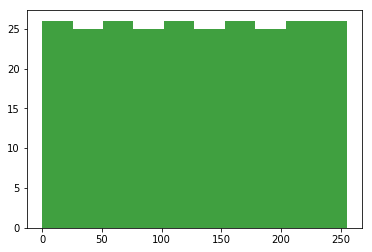

[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]


In [37]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io,color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')


IMAGES_PER_ROW = 4

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20


image = io.imread('images/racecar.png')
imageCar = image[260:350, 480:640]
"""
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
"""
# ...

ax1.imshow(image)
ax2.imshow(imageCar)

# ...

def createColorHistogram(img, binCount = 256, out = plt):
    roi = color.rgb2hsv(imageCar)
    #io.imshow(roi)
    
    buckets = {}
    
    for i in range(256):
        buckets[i/256] = i
    
    for x in range(roi.shape[0]):
        for y in range(roi.shape[1]):
            print(roi[x][y])
            break
        break
    
    print(buckets)    
    n, bins, patches = plt.hist(list(buckets.values()),  facecolor='g', alpha=0.75)  
    plt.show()
    
    print(bins)

createColorHistogram(image)


* stelle das Histogramm über dem Hue-Kanal für das gesamte Bild und für den Ausschnitt (x,y) = (480, 260) bis (640, 350) dar. Variiere auch mal testweise die Zahl der Bins(**RESULT**)


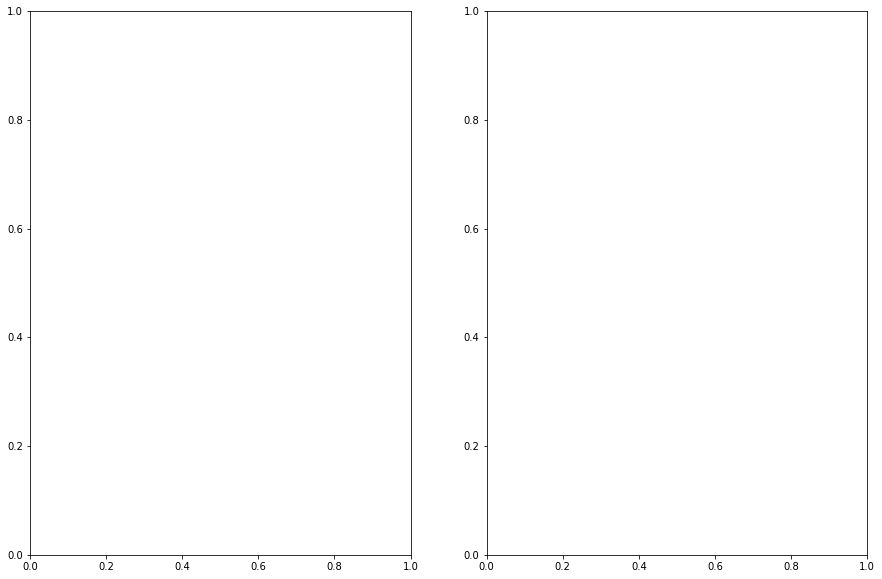

In [2]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
    
# histCar100 = createColorHistogram(imageCar, 100, ax1)
# histCar10 = createColorHistogram(imageCar, 10, ax1)


## Wahrscheinlichkeitsverteilung
* implementiere die Methode aus der Vorlesung, die Dir - gegeben ein Hue-Histogramm - die Objekt-Wahrscheinlichkeitsverteilung für ein neues Bild berechnet. 
* erzeuge das Histogramm des Autos aus dem Bild "racecar.png" und wende die neue Funktion auf das letzte frame des Videos (images/racecar/151.jpg) an (**RESULT**)

In [10]:
# Tip: in der Nacht sind alle Katzen grau ;)
# def createProbDistribution(image, objectHist, nbins, minSaturation, minValue):
    #...
            
lastFrame = io.imread('images/racecar/151.jpeg')
# histogramCar = createColorHistogram(imageCar, nbins, ax1)
# probDistr = createProbDistribution(lastFrame, histogramCar, nbins, MIN_SATURATION_CAR, MIN_VALUE_CAR)
# io.imshow(probDistr)

### ROI auf Bild anzeigen


In [13]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="red"
        )
    )
    
    out.imshow(image)

# showRoiFrame(image, 480, 260, 160, 90)

##  Exercise 1.2 - Mean Shift
* Implementiere die Verschiebung und des ROI wie in der Vorlesung beschrieben. Teste den Algorithmus auf den Bildfolgen "images/racecar/*.jpg" oder "images/taco/*.jpg". Wähle das Tracking-Fenster geeignet (zur Reduktion der Dateigröße habe ich die Bilder um Faktor 2 verkleinert, d.h. die ROI von oben muss entsprechend angepasst werden). 
* Zeichne als Ausgabe die Trajektorie (die Bewegungsspur) der Objekte, wie durch CAMSHIFT zurückgegeben. (**RESULT**)

##  Exercise 1.2 - CAMSHIFT
* erweitere Deinen Algorithmus um die Anpassung der Größe des ROI und das Finden der Objektorientierung
* führe den Algorithmus wieder auf eine der Bildfolgen aus und zeichne eine Ellipse auf das Bild, die die gefundenen Parameter repräsentiert (**RESULT**)